### RSCAM Assessment 3


### Simulating Langevin dynamics

We assume we have some complicated potential energy function $U(q)$, and the target distribution $\rho_\beta(q)$ where 
$$\rho_\beta(q) = \frac1{Z_\beta} \exp(-\beta U(q)),\qquad Z_\beta=\int_{-\infty}^\infty \exp(-\beta U(q) )\,\rm{d}q.$$
Ultimately we want to compute averages with respect to this distribution, which we can write as an integral against $\rho_\beta(q)$.

If we augment our distribution to include momentum $p$, then we can write 
$$\rho_\beta(q,p) = \frac1{\hat{Z}_\beta} \exp(-\beta H(q,p) ),\qquad \hat{Z}_\beta=\int_{-\infty}^\infty \exp(-\beta H(q,p) )\,\rm{d}q\rm{d}p,$$
where $H$ is the familiar Hamiltonian, or total energy function, that we've seen before
$$H(q,p) = \frac12 \|p\|^2 + U(q)$$
where we have assumed mass is 1 for all degrees of freedom.   (It is easy to change this if we wanted to include a nonunit mass, but just complicates the notation a bit.)

As $q$ and $p$ are independent, we can integrate out over the momentum variables and recover the correct sampling in $q$.  This means that we can think of the momenta as intermediate or 'auxiliary' variables if our main goal is to compute averages of q-dependent functions.

The momentum variables are useful as they can allow a system to continue going in an unfavourable direction (i.e. up barriers) via inertia. This property is lacking in, for example, Brownian dynamics.

The equations of motion for Langevin dynamics are
$${ \begin{array}{rcl}
\dot{q} &=& p\\
\dot{p} &=& -\nabla U(q) - \gamma p + \sqrt{2\gamma /\beta} \dot{W}\end{array}}$$
where $W$ is a Wiener process, and $\gamma>0$ is the _friction constant_, a parameter that describes how rapidly energy is dissipated from the system to its surroundings as well as the rate at which the momentum is randomized ($\gamma$ should be viewed as a rate). Note that if $\gamma=0$ then the system reduces to the constant energy (Hamiltonian) dynamics that we looked at earlier in the term when we studied symplectic methods. If $\gamma$ is large, or infinite, then solutions will tend towards solutions to Brownian dynamics, as mentioned in lecture.   In between, $\gamma$ alters the way we converge to equilibrium (or the rate at which averages of functions taken along stochastic paths converge to their long term (ensemble) averages.

We can rewrite Langevin dynamics as the sum of three terms:


$$\left[ \begin{array}{c} \dot{q}\\ \dot{p} \end{array}\right]
= \underbrace{\left[\begin{array}{c} p \\0 \end{array}\right]}_\text{A}
+ \underbrace{\left[\begin{array}{c} 0\\F(q) \end{array}\right]}_\text{B}
+ \underbrace{\left[\begin{array}{c} 0\\-\gamma p + \sqrt{2\gamma/\beta} \dot{W} \end{array}\right]}_\text{O}.$$
As usual $F(q)=-\nabla U(q)$ denotes the force.

As discussed in lecture, we can solve each of the pieces _exactly_ in the weak (distributional) sense:

$$\text{(A) dynamics step}$$
$$ \left| \begin{array}{rcl} 
q(t+h)&\leftarrow&q(t) + h  p(t) \\
\qquad p(t+h)&\leftarrow&p(t)
\end{array}\right.$$

$$\text{(B) dynamics step}$$
$$ \left| \begin{array}{rcl} 
q(t+h)&\leftarrow&q(t) \\
\qquad p(t+h)&\leftarrow&p(t) + h F(q(t))
\end{array}\right.$$

$$\text{(O) dynamics step}$$
$$ \left| \begin{array}{rcl} 
q(t+h)&\leftarrow&q(t) \\
R(t+h)&\leftarrow& \text{Normal}(0,I)\\
\qquad p(t+h)&\leftarrow&\exp(-\gamma h) p(t) + \sqrt{1/\beta}\sqrt{1-\exp(-2\gamma h)} R(t+h)
\end{array}\right.$$

The solution of the O step comes from the solution for the Ornstein-Uhlenbeck process, with $R(t)\in\mathbb{R}^N$ a vector of independent and identically distributed (i.i.d.) normal random numbers.

In [145]:
import numpy as np
from functools import partial
import matplotlib.pyplot as plt 
from IPython.display import HTML
import time
plt.rc('font', size=14) # makes the fonts used in graphs a bit larger (and clearer)!

### Exercise 1. [2 marks]
Complete the codes for the `B_step` and `O_step` functions below to match the above algorithms. 

In [146]:
def A_step( qp , h ):
    q,p = qp
    
    q = q + h*p
    
    return [q,p]

def B_step( qp , h, force ):
    q,p = qp
    
    F = force(q)
    p = p + h*F
    
    return [q,p]

def O_step( qp , h,gamma, beta ):
    q,p = qp
    
    alpha = np.exp(-h*gamma)
    
    R = np.random.randn( q.size ).reshape( q.shape)
    p = np.exp(- gamma*h )*p+ np.sqrt(1/beta)*np.sqrt(1-np.exp(-2*gamma*h))*R
    
    return [q,p]

Next we can define a method integrating Langevin Dynamics by performing these steps in sequence. For example, the _ABO_ method looks like this:

In [147]:
def ld_ABO(q,p,h,gamma,beta,force):
    
    # The algorithm "ABO" does A then B then O 
    
    qp = [q,p]  #this just translates the separate q and p vectors 
                #into a single vector composed from the pair.
    
    qp_A = A_step(qp , h )
    qp_AB = B_step( qp_A, h, force)
    qp_ABO = O_step( qp_AB, h, gamma, beta )
    q,p = qp_ABO
    
    return q , p 

We can feed this function into the `run_simulation` function  (see below) as the 'step_function' argument. Note that beta, the reciprocal temperature parameter, must be fed through the functions together with gamma.

In [148]:
def run_simulation( q0,p0, Nsteps, h, gamma, beta, step_function, force_function):
    
    q_traj = [np.copy(q0)] 
    p_traj = [np.copy(p0)]
    t_traj = [0]

    q = np.copy(q0) 
    p = np.copy(p0)
    t = 0 

    for n in range(Nsteps):
        q,p = step_function(q, p, h, gamma, beta, force_function)
        t = t + h 

        q_traj += [q] 
        p_traj += [p]   
        t_traj += [t] 

    q_traj = np.array(q_traj) 
    p_traj = np.array(p_traj) 
    t_traj = np.array(t_traj) 

    return q_traj, p_traj, t_traj

In discussing the evolving distribution associated to the numerical method, one normally thinks of taking a large number of separate sampling paths and using the snapshots of them at a given time as a discrete approximation to the evolving probability distribution.

On the other hand, if one is interested in the long term averages, it is not necessary to use this approach.   Rather than taking many walkers and looking at the evolving distributions, one may run a single, long simulation. It can be shown that taking averages over this long simulation is equivalent to looking at the large time limit of lots of walkers, i.e. time averages along a trajectory will still equal averages with respect to the target distribution.

For example, for a Gaussian we can look at the sampled distributions generated by a single path as follows:

In [149]:
def force_Gaussian(q):
    # U(q) = q^2 /2
    F = -q 
    return F

# Initialize one walker from a Gaussian distribution

q0 = np.random.randn(1)
p0 = np.random.randn(1)

Nsteps = 10000
h = 0.5
gamma = 1.0
beta = 1.0

# Run one long trajectory of Nsteps, using the ABO scheme
q_traj, p_traj, t_traj = run_simulation(q0, p0, Nsteps , h, gamma, beta, ld_ABO, force_Gaussian)

And then plot the resulting trajectories of the $q$ variable and the distributions marginalised in $q$ and $p$:

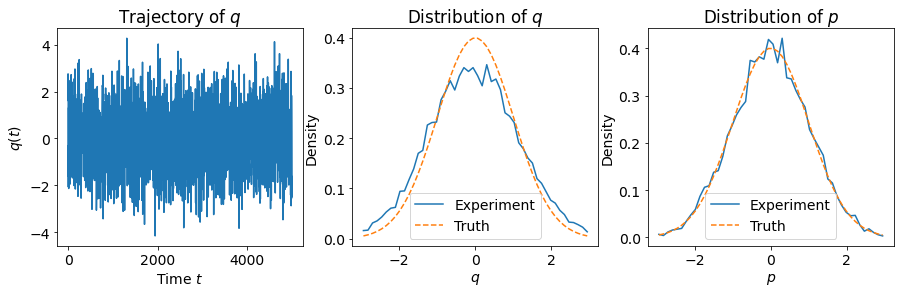

In [150]:
fig = plt.figure(figsize=[15,4])

plt.subplot(1,3,1)
plt.plot( t_traj, q_traj )
plt.title('Trajectory of $q$')
plt.ylabel('$q(t)$')
plt.xlabel('Time $t$')

plt.subplot(1,3,2) 
histogram,bins = np.histogram(q_traj,bins=50,range=[-3,3], density=True)
midx = (bins[0:-1]+bins[1:])/2
rho = np.exp(- beta*(midx**2)/2)
rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) # Normalize rho by dividing by its approx. integral
plt.plot(midx,histogram,label='Experiment')
plt.plot(midx,rho,'--',label='Truth')
plt.title('Distribution of $q$')
plt.xlabel('$q$')
plt.ylabel('Density')
plt.legend()

plt.subplot(1,3,3) 
histogram,bins = np.histogram(p_traj,bins=50,range=[-3,3], density=True)
midx = (bins[0:-1]+bins[1:])/2
rho = np.exp(- beta*(midx**2)/2)
rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) # Normalize rho by dividing by its approx. integral
plt.plot(midx,histogram,label='Experiment')
plt.plot(midx,rho,'--',label='Truth')
plt.title('Distribution of $p$')
plt.xlabel('$p$')
plt.ylabel('Density')
plt.legend()
plt.show()

Discuss the gap between the distribution of points generated by the numerical method and the exact, true Gaussian distribution.

In [151]:
def make_plots(q_traj, p_traj, t_traj):
    fig = plt.figure(figsize=[15,4])
    plt.subplot(1,3,1)
    plt.plot( t_traj, q_traj )
    plt.title('Trajectory of $q$')
    plt.ylabel('$q(t)$')
    plt.xlabel('Time $t$')

    plt.subplot(1,3,2)
    histogram,bins = np.histogram(q_traj,bins=50,range=[-3,3], density=True)
    midx = (bins[0:-1]+bins[1:])/2
    rho = np.exp(- beta*(midx**2)/2)
    rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) # Normalize rho by dividing by its approx. integral
    plt.plot(midx,histogram,label='Experiment')
    plt.plot(midx,rho,'--',label='Truth')
    plt.title('Distribution of $q$')
    plt.xlabel('$q$')
    plt.ylabel('Density')
    plt.legend()

    plt.subplot(1,3,3)
    histogram,bins = np.histogram(p_traj,bins=50,range=[-3,3], density=True)
    midx = (bins[0:-1]+bins[1:])/2
    rho = np.exp(- beta*(midx**2)/2)
    rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) # Normalize rho by dividing by its approx. integral
    plt.plot(midx,histogram,label='Experiment')
    plt.plot(midx,rho,'--',label='Truth')
    plt.title('Distribution of $p$')
    plt.xlabel('$p$')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

### Exercise 2 [6 marks]
Examine the above distributions obtained using histograms of the trajectories.  What happens to their accuracy (i.e. the difference between the histogram envelope and the dashed curve) if you (a) decrease or increase the stepsize, (b) decrease or increase the number of timesteps?  You may need quite significant increases in the number of steps to see a difference. 

Please do this carefully and systematically and pay close attention to the presentation of your results.

In [152]:
q_traj, p_traj, t_traj = run_simulation(q0, p0, Nsteps*5 , 0.1, gamma, beta, ld_ABO, force_Gaussian)

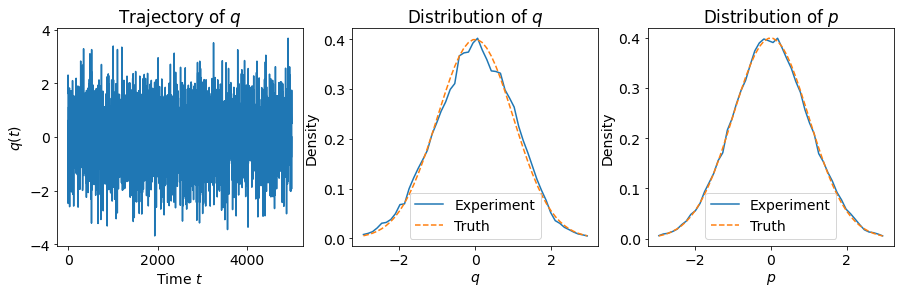

In [153]:
make_plots(q_traj, p_traj, t_traj)

## Exercise 3 [2 marks]
Implement the _BAOAB_ method.  

*Recall that if a character appears twice in the string describing the method then the corresponding integration is for time $h/2$, rather than $h$.*

In [154]:
def ld_BAOAB(q,p,h,gamma,beta, force):
    qp = [q,p]
    qp_1 = B_step( qp, h/2, force)
    qp_2 = A_step(qp_1, h/2 )
    qp_3 = O_step( qp_2, h, gamma, beta )
    qp_4 = A_step(qp_3, h/2 )
    qp_5 = B_step( qp_4, h/2, force)
    q,p = qp_5
    return q , p

# Exercise 4 [5 marks]
Refer to Exercise 2 for methodology.

Compare the exact distribution to sampled distributions computed using  _BAOAB_ by making plots of their q trajectories and q and p marginal densities (as done above for the Gaussian case). Compute distributions in both configurations ($q$) and momenta ($p$), for the potential energy function shown below. Use Nsteps = 10000, a stepsize of $h=0.1$, $\gamma=1$, and $\beta=1.0$ 
$$U(q) = q^2(.1+\sin^2(q))$$
Discuss the results obtained. 

*(Run using one path for a long enough simulation so that your histogram looks smooth. Include axis labels, legends and titles where necessary.)*

In [200]:
def my_pot(q):
    U= (q**2)*(np.sin(q)**2 +0.1)
    return U

# note - since the potential has changed, this has also changed the force
def my_force(q):
    F = -2*q*(np.sin(q)**2 +0.1) - 2*q**2*np.sin(q)*np.cos(q)
    return F

def make_plots_2(q_traj, p_traj, t_traj, gamma, beta):
    fig = plt.figure(figsize=[15,4])
    plt.subplot(1,3,1)
    plt.plot( t_traj, q_traj )
    plt.title('Trajectory of $q$')
    plt.ylabel('$q(t)$')
    plt.xlabel('Time $t$')

    plt.subplot(1,3,2)
    histogram,bins = np.histogram(q_traj,bins=50,range=[-3,3], density=True)
    midx = (bins[0:-1]+bins[1:])/2
    rho = np.exp(- beta*my_pot(midx))
    rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) # Normalize rho by dividing by its approx. integral
    plt.plot(midx,histogram,label='Experiment')
    plt.plot(midx,rho,'--',label='Truth')
    plt.title('Distribution of $q$')
    plt.xlabel('$q$')
    plt.ylabel('Density')
    plt.legend()

    plt.subplot(1,3,3)
    histogram,bins = np.histogram(p_traj,bins=50,range=[-3,3], density=True)
    midx = (bins[0:-1]+bins[1:])/2
    rho = np.exp(- beta*(midx**2)/2)
    rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) # Normalize rho by dividing by its approx. integral
    plt.plot(midx,histogram,label='Experiment')
    plt.plot(midx,rho,'--',label='Truth')
    plt.title('Distribution of $p$')
    plt.xlabel('$p$')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

def make_plots_3(q_traj, p_traj, t_traj, gamma, beta):
    fig = plt.figure(figsize=[15,4])

    plt.subplot(1,2,1)
    histogram,bins = np.histogram(q_traj,bins=50,range=[-3,3], density=True)
    midx = (bins[0:-1]+bins[1:])/2
    rho = np.exp(- beta*my_pot(midx))
    rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) # Normalize rho by dividing by its approx. integral
    plt.plot(midx,histogram,label='Experiment')
    plt.plot(midx,rho,'--',label='Truth')
    plt.title('Distribution of $q$')
    plt.xlabel('$q$')
    plt.ylabel('Density')
    plt.legend()

    plt.subplot(1,2,2)
    histogram,bins = np.histogram(p_traj,bins=50,range=[-3,3], density=True)
    midx = (bins[0:-1]+bins[1:])/2
    rho = np.exp(- beta*(midx**2)/2)
    rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) # Normalize rho by dividing by its approx. integral
    plt.plot(midx,histogram,label='Experiment')
    plt.plot(midx,rho,'--',label='Truth')
    plt.title('Distribution of $p$')
    plt.xlabel('$p$')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

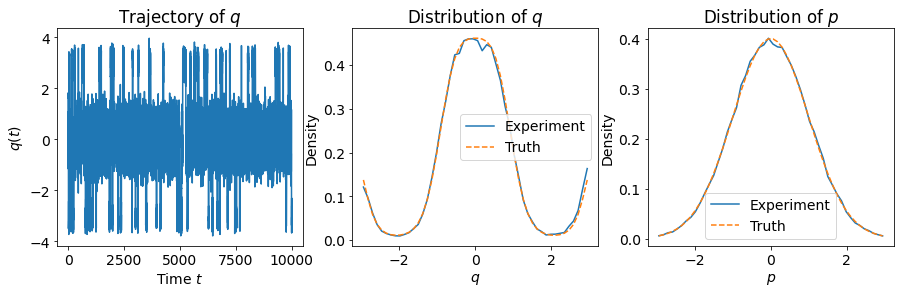

In [158]:
q_traj, p_traj, t_traj = run_simulation(q0, p0, 100000 , 0.1, 1 , 1.0, ld_BAOAB, my_force)
make_plots_2(q_traj,p_traj,t_traj,1 , 1.0)

The sampling distribution follows the exact distribution very closely, for both p and q. It seems that compared to ABO it may be slightly more accurate than ABO in this case, as the plots for the ABO method below show:

C:\Users\Administrator\AppData\Local\Temp\ipykernel_18992\1327939783.py:7: RuntimeWarning: overflow encountered in square
  F = -2*q*(np.sin(q)**2 +0.1) - 2*q**2*np.sin(q)*np.cos(q)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_18992\1327939783.py:7: RuntimeWarning: invalid value encountered in sin
  F = -2*q*(np.sin(q)**2 +0.1) - 2*q**2*np.sin(q)*np.cos(q)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_18992\1327939783.py:7: RuntimeWarning: invalid value encountered in cos
  F = -2*q*(np.sin(q)**2 +0.1) - 2*q**2*np.sin(q)*np.cos(q)


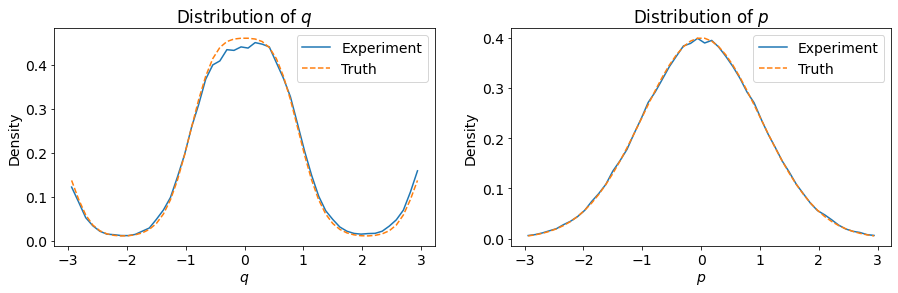

In [201]:
q_traj, p_traj, t_traj = run_simulation(q0, p0, 100000 , 0.1, 1 , 1.0, ld_ABO, my_force)
make_plots_3(q_traj,p_traj,t_traj,1 , 1.0)

We can estimate an 'observable average' of a function $\varphi(q,p)$ by calculating the average of the values of $\varphi(q_n,p_n)$ computed using the method.  For example, to calculate the average of $\varphi(q) = q^2$, just compute $$\frac{1}{N+1}\sum_{n=0}^{N}q_{n}^2$$.

### Exercise 5 [10 marks]
This exercise is open-ended and individual.

In this exercise you will explore the use of BAOAB to compute observable averages for the following observable functions:
$$\varphi_1(q) = q^2$$
$$\varphi_2(q) = e^{-q^2}$$

Important - in your experiments, leave beta fixed at 1.0 as it represents a reciprocal physical temperature, i.e. a feature of the model. Changing beta could result in a much different problem. By contrast gamma, Nsteps and stepsize h can all be viewed as 'free parameters' and they are just things that can be adjusted to get the best possible result for the least computational effort.  

You may vary any of gamma, Nsteps and stepsize.  You will need to do this systematically for each observable function.  Also bear in mind that the quantities you are computing such as an observable will have random variation due to the numbers of samples collected, and the particular stochastic paths followed.  In the limit of large N and small h, you should converge to a single exact value, but it might be beyond the abilities of your computer to do so!

Note that it is possible to compute the reference value of each average by using numerical quadrature (integration methods).  For example to compute the reference value for $\varphi_1$, first import scipy's integrate package:
> import scipy.integrate as integrate

then calculate as follows:
> Z = integrate.quad(lambda q: np.exp(- beta * my_pot(q)), -10,10)[0]

> avg = integrate.quad( lambda q: q**2 * np.exp(- beta * my_pot(q)), -10,10)[0]/Z

The division by Z is needed because the density is not normalised.  The limits -10 to 10 are somewhat arbitrary...we just need to be sure the integrand is nearly zero outside the range.

In reporting your work it is not necessary to provide every graph you generate in your notebook...in particular you should clean up your answers to improve presentation.  You may wish to focus in particular on these two questions:
<ul>
  
<li>
    Which observable is most difficult to compute, $\varphi_1$ or $\varphi_2$? Explain by first discussing the graphs of the two observable functions in relation to the graph of the configurational density function.   Clarify your statement by performing numerical experiments.
</li>
<li>  What is the best result you can obtain using either method for $\varphi_2$ with a "force budget" of 20000 F-evaluations?    Bear in mind the stochastic variation in the computed results you obtain, so you might run a number of independent sampling runs and average to compute the mean and even compute the standard deviation of the estimates you obtain. </li>
</ul>



In [159]:
import scipy.integrate as integrate
q = q_traj

# calculating the first average
Z = integrate.quad(lambda q: np.exp(- beta * my_pot(q)), -10,10)[0]
avg_1 = integrate.quad( lambda q: q**2 * np.exp(- beta * my_pot(q)), -10,10)[0]/Z

# calculating the second average:
avg_2 = integrate.quad( lambda q: np.exp(-q**2) * np.exp(- beta * my_pot(q)), -10,10)[0]/Z

# printing
print(avg_1,avg_2)

2.3539799379205 0.5653404356145665


In [160]:
def plot_traj_average(N_steps,stepsize,gamma, beta):
    '''
    For 1 trajectory, plots the observable average
    :param N_steps:
    :param stepsize:
    :param gamma:
    :param beta:
    :return:
    '''

    # taking the time
    start = time.time()

    # random initial p and q
    p0 = np.random.randn(1)
    q0 = np.random.randn(1)

    # computing the trajectory
    q_traj, p_traj, t_traj = run_simulation(q0, p0, N_steps , stepsize, gamma , beta, ld_BAOAB, my_force)

    # computing the rolling averages of the observables
    rolling_average_1 = np.cumsum(q_traj**2) / np.arange(1,len(q_traj)+1)
    rolling_average_2 = np.cumsum(np.exp(-(q_traj**2)))/ np.arange(1,len(q_traj)+1)

    # plotting the results
    fig = plt.figure(figsize=[15,4])
    plt.subplot(1,2,1)
    plt.plot(t_traj,rolling_average_1,label = 'observed average for phi_1')
    plt.plot(t_traj,np.zeros_like(t_traj) + avg_1, ':',color = 'green',label = 'computed value for phi_1')
    plt.xlabel('Number of steps')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(t_traj,rolling_average_2, label = 'observed average for phi_2')
    plt.plot(t_traj,np.zeros_like(t_traj) + avg_2, ':',color = 'green',label = 'computed value for phi_2')
    plt.xlabel('Number of steps')
    plt.legend()

    #taking the end time
    end= time.time()

    print(f"Absolute error for phi_1: {abs((q_traj**2).mean() -avg_1)} \n Absolute error for phi_2: {abs(np.exp(-(q_traj**2)).mean() -avg_2)}")
    print(f"Relative error for phi_1: {abs((q_traj**2).mean() -avg_1)/avg_1} \n Relative error for phi_2: {abs(np.exp(-(q_traj**2)).mean() -avg_2) / avg_2}")
    print(f"Time elapsed: {end-start}")

In [161]:
def plot_averages(N_sims,N_steps,stepsize,gamma, beta):
    '''
    Plots the averages of N_sims trajectories compared to their computed values against the number of steps
    :param N_sims: Number of random simulations to run
    :param N_steps: Number of steps to take in each simulation
    :param stepsize: stepsize to use in each simulation
    :param gamma: gamma to use
    :return:
    '''
    # taking the start time
    start = time.time()

    # random initial p and q
    p0 = np.random.randn(N_sims)
    q0 = np.random.randn(N_sims)

    q_traj, p_traj, t_traj = run_simulation(q0, p0, N_steps , stepsize, gamma , beta, ld_BAOAB, my_force)
    Z = integrate.quad(lambda q: np.exp(- beta * my_pot(q)), -10,10)[0]

    avg_1 = integrate.quad( lambda q: q**2 * np.exp(- beta * my_pot(q)), -10,10)[0]/Z
    avgs_1 = (np.average(np.multiply(q_traj, q_traj), axis = 1))

    fig = plt.figure(figsize=[15,4])
    plt.subplot(1,2,1)
    plt.plot( t_traj, avgs_1, color = 'blue', label = 'Observed average of q^2')
    plt.plot( t_traj, np.zeros_like(t_traj)+ avg_1, ':',color = 'green', label = 'Computed average of q^2')
    plt.legend()
    plt.xlabel('Time $t$')

    avgs_2 = (np.average(np.exp(-np.multiply(q_traj, q_traj)), axis = 1))
    avg_2 = integrate.quad( lambda q: np.exp(-q**2) * np.exp(- beta * my_pot(q)), -10,10)[0]/Z
    plt.subplot(1,2,2)
    plt.plot( t_traj, avgs_2, color = 'blue', label = 'Observed average of exp(-q^2)')
    plt.plot( t_traj, np.zeros_like(t_traj) + avg_2, ':',color = 'green', label = 'Computed average of exp(-q^2)')
    plt.legend()
    plt.xlabel('Time $t$')
    end= time.time()
    print(f"Absolute error for phi_1: {abs(avgs_1[-1] -avg_1)} \n Absolute error for phi_2: {abs(avgs_2[-1] -avg_2)}")
    print(f"Relative error for phi_1: {abs((q_traj**2).mean() -avg_1)/avg_1} \n Relative error for phi_2: {abs(np.exp(-(q_traj**2)).mean() -avg_2) / avg_2}")
    print(f"Time elapsed: {end-start}")

Absolute error for phi_1: 0.4949804570907901 
 Absolute error for phi_2: 0.053557765628504894
Relative error for phi_1: 0.21027386390049463 
 Relative error for phi_2: 0.0947354235687806
Time elapsed: 1.523026704788208


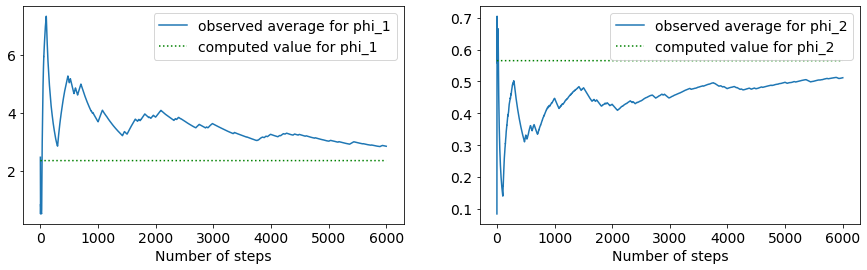

In [207]:
plot_traj_average(30000,.2,1,1)

Absolute error for phi_1: 0.034938465456317847 
 Absolute error for phi_2: 0.009549992545876074
Relative error for phi_1: 0.1105586002427826 
 Relative error for phi_2: 0.01754756149289719
Time elapsed: 1.659742832183838


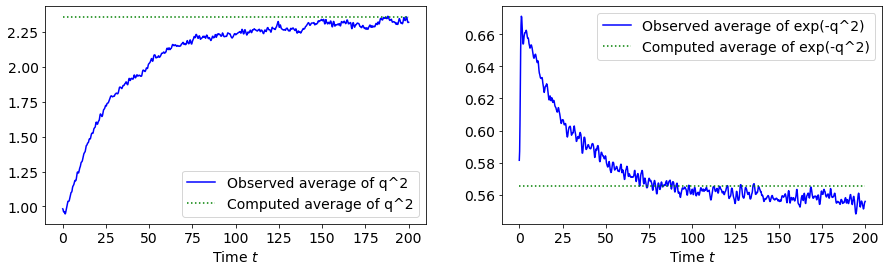

In [206]:
plot_averages(10000,1000,.2,1,1)

As shown above, the average of 10,000 trajectories of 1000 steps takes the same amount of time to run as the average of one trajectory but absolute absolute errors and relative errors are lower. In all cases the relative error is much lower for $\varphi_2$, so in that sense it is easier to compute.

Absolute error for phi_1: 0.032340521458356086 
 Absolute error for phi_2: 0.008292357936347194
Relative error for phi_1: 0.01373865636549376 
 Relative error for phi_2: 0.014667901699500397
Time elapsed: 23.83844780921936


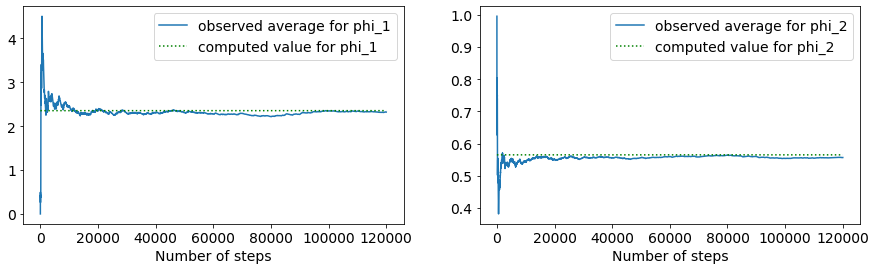

In [164]:
plot_traj_average(600000,.2,1,1)

Absolute error for phi_1: 0.04539334041512255 
 Absolute error for phi_2: 0.008087272377856003
Relative error for phi_1: 0.04258710202923531 
 Relative error for phi_2: 0.005181500776679586
Time elapsed: 23.43585777282715


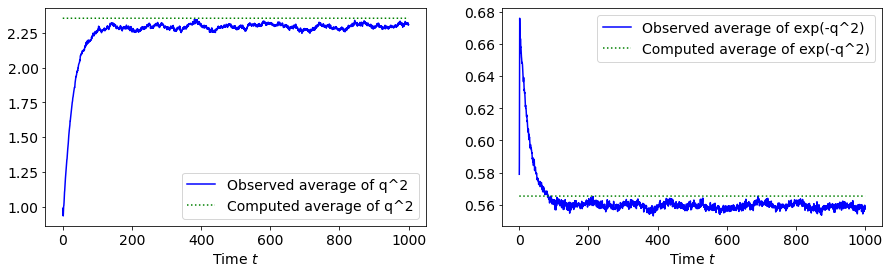

In [165]:
plot_averages(35000,5000,.2,1,1)

Running both functions over a longer timespan shows that the advantage of the new method are diminished, it seems to give more efficient estimators only for smaller timesteps.

In varying the parameters below I will use the second method, running N_sims simulations each taking N_steps steps and averaging over them

In [166]:
def vary_parameters(gamma_min, gamma_max, N_steps_min, N_steps_max, stepsize_min, stepsize_max, beta, nsims):
    '''
    Creates plots of the results after varying three parameters; gamma, N_steps, and stepsize
    :param gamma_min: minimum value of gamma
    :param gamma_max: maximum value of gamma
    :param N_steps_min: minimum number of steps
    :param N_steps_max: maximum number of steps
    :param stepsize_min: minimum stepsize
    :param stepsize_max: maximum stepsize
    :param beta: beta parameter to use
    :param nsims: number of simulations to average over
    :return:
    '''
    fig = plt.figure(figsize=[15,20])
    Z = integrate.quad(lambda q: np.exp(- beta * my_pot(q)), -10,10)[0]

    avg_1 = integrate.quad( lambda q: q**2 * np.exp(- beta * my_pot(q)), -10,10)[0]/Z
    avg_2 = integrate.quad( lambda q: np.exp(-q**2) * np.exp(- beta * my_pot(q)), -10,10)[0]/Z


    # random initial p and q
    p0 = np.random.randn(nsims)
    q0 = np.random.randn(nsims)

    # calculating the average values of the parameters
    avg_stepsize = (stepsize_min + stepsize_max)/2
    avg_nsteps = (N_steps_min + N_steps_max)//2
    avg_gamma = (gamma_min + gamma_max)/2

    # running the simulation for each gamma:
    gammas =np.linspace(gamma_min, gamma_max, 10)
    errors_1 = []
    errors_2 = []
    for gamma in gammas:
        q_traj, p_traj, t_traj = run_simulation(q0, p0, avg_nsteps, avg_stepsize, gamma , beta, ld_BAOAB, my_force)
        errors_1.append(abs((q_traj[-1]**2).mean() - avg_1))
        errors_2.append(abs((np.exp(-q_traj[-1]**2)).mean() - avg_2))


    plt.subplot(3,2,1)
    plt.title("Absolute error of phi_1 vs gamma ")
    plt.plot(gammas, errors_1)
    plt.xlabel("Gamma")
    plt.ylabel("Absolute error")
    plt.subplot(3,2,2)
    plt.plot(gammas, errors_2)
    plt.xlabel("Gamma")
    plt.title("Absolute error of phi_2 vs gamma ")
    plt.ylabel("Absolute error")

    # running the simulation for each stepsize:
    stepsizes =np.linspace(stepsize_min, stepsize_max, 20)
    errors_1 = []
    errors_2 = []
    for stepsize in stepsizes:
        q_traj, p_traj, t_traj = run_simulation(q0, p0, avg_nsteps, stepsize, avg_gamma , beta, ld_BAOAB, my_force)
        errors_1.append(abs((q_traj[-1]**2).mean() - avg_1))
        errors_2.append(abs((np.exp(-q_traj[-1]**2)).mean() - avg_2))

    plt.subplot(3,2,3)
    plt.plot(stepsizes, errors_1)
    plt.xlabel("Stepsize")
    plt.ylabel("Absolute error")
    plt.title("Absolute error of phi_1 vs stepsize")
    plt.subplot(3,2,4)
    plt.plot(stepsizes, errors_2)
    plt.xlabel("Stepsize")
    plt.ylabel("Absolute error")
    plt.title("Absolute error of phi_2 vs stepsize")

    # running the simulation for each N_steps
    N_steps = np.linspace(N_steps_min, N_steps_max, 10)
    errors_1 = []
    errors_2 = []
    for nsteps in N_steps:
        q_traj, p_traj, t_traj = run_simulation(q0, p0, round(nsteps), avg_stepsize, avg_gamma , beta, ld_BAOAB, my_force)
        errors_1.append(abs((q_traj[-1]**2).mean() - avg_1))
        errors_2.append(abs((np.exp(-q_traj[-1]**2)).mean() - avg_2))

    plt.subplot(3,2,5)
    plt.plot(N_steps.round(), errors_1)
    plt.xlabel("Number of steps taken")
    plt.ylabel("Absolute error")
    plt.title("Absolute error of phi_1 vs number of steps")
    plt.subplot(3,2,6)
    plt.xlabel("Number of steps taken")
    plt.ylabel("Absolute error")
    plt.title("Absolute error of phi_2 vs number of steps")
    plt.plot(N_steps.round(), errors_2)

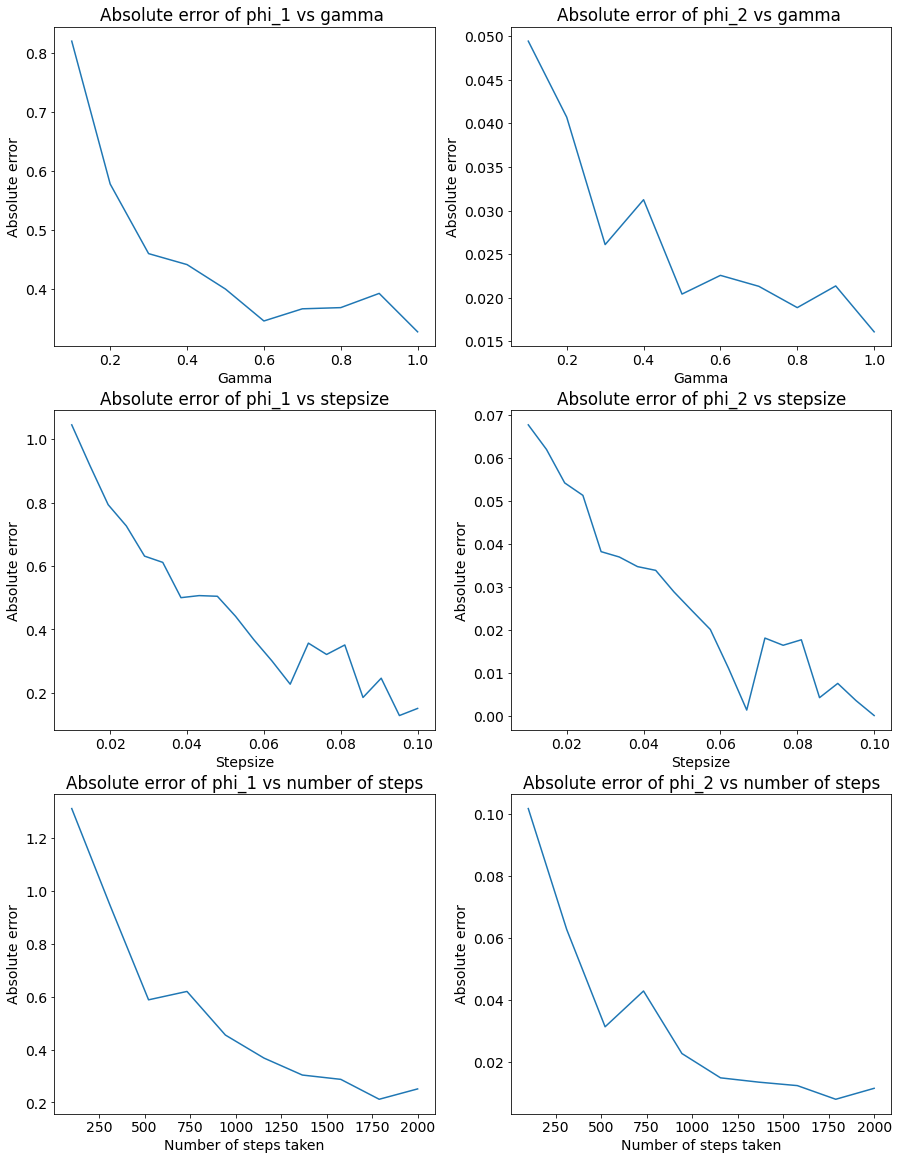

In [167]:
vary_parameters(0.1, 1, 100, 2000, 0.01, 0.1,1,5000)

Absolute error decreases as number of steps taken increase, but counterintuitively also as stepsize increases, and additionally it decreases as gamma increases.

***

### Bayesian inference in data science

The purpose of stochastic calculation is usually to calculate integrals (averages) with respect to a target distribution. We shall look at an application for this in Bayesian inference for Gaussian mixture models.  This discussion is very compressed. For a more in-depth (but still very readable) look at Bayesian inference in mixture models, see Ref [1] below.

We will look at one example for inferring a statistical property from data via sampling.

Let's assume there are three types of data mixed together: A, B and C. For concreteness, you could suppose that we have combined three data sets containing mean August high temperatures from three cities at different latitudes which are assumed to be modelled by Gaussian distributions, let us say A = Helsinki, B= Ulan Bator, C = Buenos Aires.  For each city we have a mean and a standard deviation of the corresponding Gaussian.   

If we combine datasets of equal size of August high temperatures from the three cities, we may make the natural ansatz that that any given datum $y$ is modelled by the _probability distribution_ $\hat{\rho}$ of $y$ whose density is just the sum of the three Gaussians.  To simplify things we will further assume in the following that all three of the standard deviations are 3C,  whereas the mean temperatures are unknown.

$$ \hat{\rho}(y\,|\,\mu_A,\mu_B,\mu_C) \propto \exp({-(y-\mu_A)^2/18}) + \exp({-(y-\mu_B)^2/18}) + \exp({-(y-\mu_C)^2}/18)$$

The "18" in each denominator is just $2\sigma^2$, where $\sigma=3$ for each component.

If we know the values of $\mu_A,\,\mu_B$ and $\mu_C$ then we can determine the likelihood of a given temperature coming from the mixture using the above formula. But what if we have the data, and just know there are three cities, but we don't know the three mean temperatures? We can use Bayes theorem to infer them.  That is, we can find the probability distribution for the centres given the data. 

If we have a set of $N$ datapoints $Y = \{y_i\}$, then we can write the distribution for the centres as 

$$ \rho(\mu_A,\mu_B,\mu_C\,|\,Y) \propto  \rho_\text{prior}(\mu_A,\mu_B,\mu_C) \prod_{i=1}^N \hat{\rho}(y_i\,|\,\mu_A,\mu_B,\mu_C),$$
where $\rho_\text{prior}$ is the _prior_ which regularizes the combined distribution, and $\hat{\rho}$ is the _likelihood_ defined above.

The simplest approach to studying the Bayesian model would be to use an 'expectation maximization' method which involves finding the mode (or modes, in this case) of the distribution by maximizing the density.  We will look at a more nuanced method that 
instead explores the probability distribution $\rho$ for the means given some temperature data $Y$. 

The distribution $\rho$ looks very different to the previous distributions we have seen, as there is no potential energy $U(q)$. We will think of $q=[\mu_A,\mu_B,\mu_C]$ and as we can write $\rho(q) = \exp(-\log(\rho(q)))$ we can then think of an effective potential $U(q) = -\log(\rho(q))$.

Thus we have 

$$ U(\mu_A,\mu_B,\mu_C) = -\log( \rho_\text{prior}(\mu_A,\mu_B,\mu_C) ) - \sum_{i=1}^N \log( \hat{\rho}(y_i\,|\,\mu_A,\mu_B,\mu_C) )$$


In data science and statistics, $U$ is called the negative _log-posterior_ instead of the energy.


Ref [1]: http://www.cs.toronto.edu/~rgrosse/csc321/mixture_models.pdf

In [168]:
file_object = open('temperatures.npy', 'rb')
Y= np.load(file_object)
print(Y)

[24.87303609 18.16473076 18.41548474 16.78109413 22.59622289 13.09538391
 25.23443529 17.7163793  20.95711729 19.25188887 24.38632381 13.81957787
 19.03274839 18.84783694 23.40130833 16.7003262  19.48271538 17.36642475
 20.12664124 21.74844564 16.69814247 23.43417113 22.70477216 21.50748302
 22.70256785 17.94881642 19.63132932 17.1926917  19.19633576 21.5910664
 17.92501774 18.80973942 17.9384819  17.46438308 17.98626161 19.9620062
 16.64806895 20.70324709 24.97940653 22.22613248 19.42449334 17.33711311
 17.75852512 25.0773638  20.15242326 18.08901306 20.57274645 26.30076541
 20.36047686 21.85160933 20.90051096 18.94325046 16.57244541 18.95197183
 19.3733173  21.75986957 22.51695024 22.79330624 20.85676198 22.65542349
 17.73680618 23.75860447 21.53878946 19.10572149 21.46555444 19.77328486
 23.39488816 24.55945045 26.55672622 15.81051099 15.66765858 18.48660241
 20.48011121 22.62850676 20.94690484 13.93339635 19.08138796 22.48392393
 20.69028421 22.28603354 19.33301557 19.39772579 20.5

And then we can make a histogram to look at the distribution of the data:

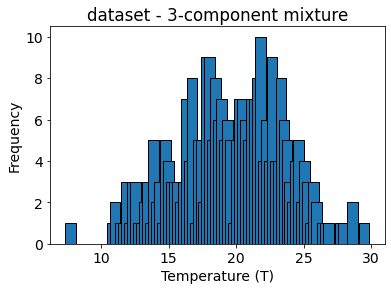

In [169]:
histogram,bins = np.histogram(Y,bins=100)
mid_bins = (bins[:-1]+bins[1:])/2
plt.bar(mid_bins,histogram,edgecolor='k')
plt.xlabel('Temperature (T)')
plt.ylabel('Frequency')
plt.title('dataset - 3-component mixture')
plt.show()

As we can see here, the temperatures look a bit of a mess, with some low values, even down to under 10 and some high values up to about 30.  The next challenge is to unravel this mess and figure out what the temperatures are for the three cities.  Can you guess this from the above picture?  If you can you are a statistical genius!   It is not at all obvious what the three temperature are.  (...and no peaking using google!)

We shall use a Gaussian prior with a large variance, just to keep us from sampling e.g. negative numbers. We will put the centre of the prior at 20, which is roughly the mean of the data.  Let us take $\sigma =10$  for each of the three means in the prior.

$$ \rho_\text{prior}(\mu_A,\mu_B,\mu_C) \propto \exp({-(20-\mu_A)^2/200}) \exp({-(20-\mu_B)^2/200}) \exp({-(20-\mu_C)^2/200}) $$

### Exercise 6 [3 marks]
Create a function that takes the value of the position $q$ and the data vector $y$, and outputs the value of $U(q)$. 

*(NOTE: Try to avoid using a loop to sum over all of the data as it will be very slow, and instead work with vectors as much as possible. Don't forget U includes the prior and the likelihood.)*

In [170]:
def U(q,y):
    m1,m2,m3 = q
    likelihoods = np.log( np.exp((-(y - m1)**2)/18) + np.exp((-(y - m2)**2)/18) + np.exp((-(y - m3)**2)/18))
    u = likelihoods.sum() + np.log( np.exp( -(20 - m1)**2/200 )*np.exp( -(20 - m2)**2/200 )*np.exp( -(20 - m3)**2/200 ) )
    return u

In [178]:
def U_1(m1,m2,m3,y):
    '''
    A function taking as input the individual components of the position q, and the data y, and returning U(q,y)
    :param m1: the first component of q
    :param m2: the second component of q
    :param m3: the third component of q
    :param y: the data
    :return:
    '''
    q = m1,m2,m3
    return U(q,y)

In [172]:
# To check:
U( [15,20,25], Y) - U( [16,21,26], Y)
# This should give approximately -11.2

11.230590033085662

### Exercise 7 [4 marks]
Create a function that takes the position $q$ and data $y$ and returns the force $\nabla U(q)$.

In [173]:
from scipy.misc import derivative

In [174]:
def force(q,y):
    '''
    Calculates the force at a position q given data y
    :param q: the position
    :param y: the data
    :return: the potential and three components of the force vector
    '''

    # extracting m1, m2 and m3 from the position q
    m1,m2,m3 = q

    # calculating the derivatives of the potential
    f1 = derivative(lambda q: U_1(q,m2,m3,y), m1, dx = 2**(-20))
    f2 = derivative(lambda q: U_1(m1,q,m3,y), m2, dx =  2**(-20))
    f3 = derivative(lambda q: U_1(m1,m2,q,y), m3, dx =  2**(-20))

    # calculating the potential
    u = U(q,y)
    
    return -u, f1,f2,f3

In [175]:
force( [15,16,31], Y)
# This should give force components as
#(173.40950408107503, 33.95278379480335, 51.00213777256805, -31.13748859782598)

(173.40950408107503,
 33.952783808112144,
 51.00213775038719,
 -31.137488588690758)

### Exercise 8 [6 marks]
Use your force routine to generate samples from $\rho$ by generating one long Langevin dynamics trajectory (more, possibly much more, than 10,000 steps). 

**Plot envelopes of the histograms of the distributions of $\mu_A,\mu_B,\mu_C$ on the same axis.**

You should see that the values tend to settle into basins around the three defined values.

*(Use BAOAB as your integrator.  It is up to you to choose a sensible stepsize $h$ and friction $\gamma$, and run for long enough to get smooth curves.)*

Discuss the three envelope curves.    You should comment on their similarities and differences. The fact that there are three modes creates an interesting problem: there is  an interchangeability in the data.  We could swap any two of the $\mu_\alpha$ and it would not change the distribution of the data.  This ability to swap parameters is sometimes referred to as fungibility and it makes the study slightly more difficult.

In [176]:
def new_force(q):
    '''
    Defining a new force function to use the global variable Y
    :param q: the position
    :return: a numpy array of the three components of the force
    '''
    _, f1, f2, f3 =force(q,Y)
    return np.array([f1,f2,f3])

def new_U(q):
    '''
    Defining a new force funtion to use the global variable Y
    :param q: the position
    :return: a scalar value of the potential at that position.
    '''
    return U(q,Y)

In [179]:
def make_plots_2(q_traj,t_traj):
    '''
    Plots the trajectory of q over time, and also the distributions of q1, q2 and q3
    :param q_traj: trajectory of q
    :param t_traj: trajectory of time
    :return:
    '''

    # Setting up the figure and plotting the trajectory
    fig = plt.figure(figsize=[15,4])
    plt.subplot(1,3,1)
    plt.plot( t_traj, q_traj )
    plt.title('Trajectory of $q$')
    plt.ylabel('$q(t)$')
    plt.xlabel('Time $t$')

    # plotting the histograms for each mu
    plt.subplot(1,3,2)
    histogram1,bins1 = np.histogram(q_traj[:,0], bins = 250,density = True)
    histogram2,bins2 = np.histogram(q_traj[:,1], bins = 250,density = True)
    histogram3,bins3 = np.histogram(q_traj[:,2], bins = 250,density = True)

    midx = (bins1[0:-1]+bins1[1:])/2
    plt.plot(midx,histogram1,label='mu 1', color = 'green')
    plt.xlim([10,30])

    midx = (bins2[0:-1]+bins2[1:])/2
    plt.plot(midx,histogram2,label='mu 2', color = 'blue')
    plt.xlim([10,30])

    midx = (bins3[0:-1]+bins3[1:])/2
    plt.plot(midx,histogram3,label='mu 3', color = 'red')
    plt.xlim([10,30])

    plt.title('Distribution of $q$')
    plt.xlabel('$q$')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

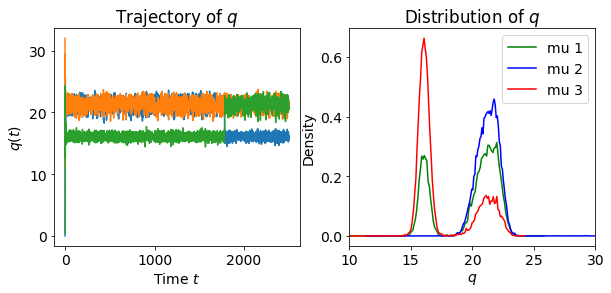

In [186]:
# setting the initial p and q
p0 = np.array([0.5,1,0])
q0 =np.array([2**(-5),2**5,.5])

# running the simulation and plotting
q_traj, p_traj, t_traj = run_simulation(q0, p0, 25000 , 0.1, 1 , 1.0, ld_BAOAB, new_force)
make_plots_2(q_traj,t_traj)

It can be hard to visualize the system when we have more than two dimensions, so people often use a pair of _collective variables_ and plot results in those instead.

### Exercise 10 [6 marks]

Plot a 2D histogram of your sampled trajectory in the $C_1$ and $C_2$ collective variable coordinates listed below.

$$ C_1 = \mu_B - \mu_A $$
$$ C_2 = 2*\mu_C - \mu_B - \mu_A $$

These formulas are chosen by trial and error to provide a suitable 2d projection of the system to separate the important domains.

_(You may wish to plot the logarithm of the histogram value instead, which is more closely related to energy and makes a nice picture.)_

You should see a finite set of regions where sampling is concentrated.
(4 marks)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]),
 array([-8.71780781, -8.31094223, -7.90407665, -7.49721107, -7.0903455 ,
        -6.68347992, -6.27661434, -5.86974876, -5.46288318, -5.05601761,
        -4.64915203, -4.24228645, -3.83542087, -3.42855529, -3.02168972,
        -2.61482414, -2.20795856, -1.80109298, -1.3942274 , -0.98736183,
        -0.58049625, -0.17363067,  0.23323491,  0.64010049,  1.04696606,
         1.45383164,  1.86069722,  2.2675628 ,  2.67442838,  3.08129396,
         3.48815953,  3.89502511,  4.30189069,  4.70875627,  5.11562185,
         5.52248742,  5.929353  ,  6.33621858,  6.74308416,  7.14994974,
         7.55681531,  7.96368089,  8.37054647,  8.77741205,  9.18427763,
         9.5911432 ,  9.99800878, 10.40487436, 10.81173994, 11.21860552,
        11.6254711 , 

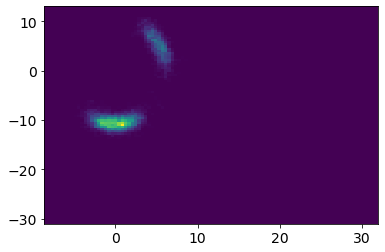

In [187]:
# defining c1 and c2
C1 = q_traj[:,1] - q_traj[:,0]
C2 = 2*q_traj[:,2] - q_traj[:,1] - q_traj[:,0]

# plotting the 2D histogram
plt.hist2d(C1, C2, bins = 100)

The problem has a symmetry in it, due to invariance under label permutation.   This means that the three sampled regions above are really effectively the same region with some projection mapping between them. We can remove this by collapsing the results onto one well.

In general finding this projection can be very difficult, but here it is easy to accomplish. A transition between any of the three regions amounts to two of the $\mu$ values swapping positions, so we can undo that by sorting our trajectory to maintain a size ordering.

### Exercise 11 [6 marks]
Use `np.sort` to create a copy of your trajectory with sorted components so that $\mu_A<\mu_B<\mu_C$. Plot a new histogram of the distributions of the sorted $\mu_A,\mu_B,\mu_C$ on the same axis, and print the means of each of the three coordinates.

You should see that each density is concentrated around just one value.   What are the high temperatures in August in the three cities?

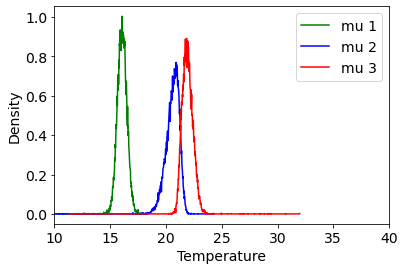

In [188]:
# sorting using np.sort
sorted_q = np.sort(q_traj)


plt.plot()

# creating the histograms for each mu
histogram1,bins1 = np.histogram(sorted_q[:,0], bins = 1000,density = True)
histogram2,bins2 = np.histogram(sorted_q[:,1], bins = 1000,density = True)
histogram3,bins3 = np.histogram(sorted_q[:,2], bins = 1000,density = True)
midx1 = (bins1[0:-1]+bins1[1:])/2
midx3 = (bins3[0:-1]+bins3[1:])/2
midx2 = (bins2[0:-1]+bins2[1:])/2


# plotting the histograms for each mu
plt.plot(midx1,histogram1,label = 'mu 1', color = 'green')
plt.xlim([10,40])

plt.plot(midx2,histogram2,label = 'mu 2', color = 'blue')
plt.xlim([10,40])

plt.plot(midx3,histogram3,label = 'mu 3', color = 'red')
plt.xlim([10,40])

plt.ylabel('Density')
plt.xlabel('Temperature')
plt.legend()
plt.show()

In [210]:
print(f"mean 1: {(sorted_q[:,0]).mean()} \n mean 2: {(sorted_q[:,1]).mean()} \n mean 3: {(sorted_q[:,2]).mean()} ")

mean 1: 16.066744861111122 
 mean 2: 20.59208253956129 
 mean 3: 21.94260731970435 


**Optional:**
1. Use your A, B and O pieces to implement some higher-order Yoshida Langevin dynamics schemes.
2. Demonstrate that the long-time sampling error for OBABO is second order for $q^2$, and BAOAB is second-order for $p^2$, in the Gaussian case.
3. Study the stability for the BAOAB scheme as $\gamma$ is increased.
4. Modify the three temperatures example to calculate the standard deviations as well as the means from data.  
5. Find the height of the barrier between two of the regions in the three-region histogram.